In [9]:
import os
import math

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.ddpm.denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, Dataset1D, Trainer1D
from scorefield.models.ddpm.gaussian_diffusion import Diffusion
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_batch

import matplotlib.pyplot as plt
import itertools
import random


In [2]:
# Args
config_dir = "./scorefield/configs/diffusion.yaml"
args = load_config(config_dir)
device = args['device']

model_path = os.path.join(args['log_path'], args['model_path'])

# map_img = Image.open("map.png")
bg = Image.open('assets/background0.png')
wastes = []
wastes.append(Image.open('assets/waste0.png'))
wastes.append(Image.open('assets/waste4.png'))
wastes.append(Image.open('assets/waste5.png'))

epochs = args['epochs']
batch_size = args['batch_size']
goal_num = args['goal_num']
goal_bounds = args['goal_bounds']
agent_bounds = args['agent_bounds']
eval_samples = args['eval_samples']

In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8)
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, x_t, t):
        score_map = super().forward(obs, t)
        score = bilinear_interpolate_batch(score_map, x_t)    # output: (B,2)
        return score

img_size = args['image_size']
noise_steps = args['noise_steps']
train_lr = args['train_lr']
beta_start = args['beta_start']
beta_end = args['beta_end']
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = Diffusion(
    input_size = (2,), 
    noise_steps= noise_steps,
    device=device,
    beta_start=beta_start,
    beta_end=beta_end,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

In [ ]:
# Train with single goal

for iters in tqdm(range(goal_num * epochs)):    
    goals = gen_goals(goal_bounds, train_goal_num)
    expanded_goals = goals.unsqueeze(1).expand(-1, n, -1)
    optim.zero_grad()
    
    random_offsets = (torch.rand(*expanded_goals.shape, device=goals.device, dtype=goals.dtype) * 2 - 1.) * 0.1
    x0 = (expanded_goals + random_offsets).view(-1,2)
    obs = overlay_image(bg, img_size, wastes, x0)
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    x_noisy, noise = diffusion.forward_diffusion(x0, t)
    noise_pred = model(obs, x_noisy, t)
    loss =  F.l1_loss(noise, noise_pred)
#     loss = F.mse_loss(noise, noise_pred)
    loss.backward()
    optim.step()
    
    if iters % 500 == 0:
        print(f"iter {iters}: {loss.item()}")


In [ ]:
# Train with single + multiple goals

n = goal_num // len(wastes)

for iters in tqdm(range(epochs)):
    gs = random.randrange(goal_num)        
    goals = gen_goals(goal_bounds, goal_num, dist=0.3)
    
    expanded_goals = goals.unsqueeze(1).expand(-1, n, -1)
    optim.zero_grad()
    
    random_offsets = (torch.rand(*expanded_goals.shape, device=goals.device, dtype=goals.dtype) * 2 - 1.) * 0.1
    goal_pos = (expanded_goals + random_offsets).view(-1,2).unsqueeze(-2)

    new_obs, x0 = combine_objects(bg, img_size, wastes, goal_pos)
        
    t = diffusion.sample_timesteps(len(x0)).to(device)
    
    x_noisy, noise = diffusion.forward_diffusion(x0, t)
    noise_pred = model(new_obs, x_noisy, t)
    loss =  F.l1_loss(noise, noise_pred)

    loss.backward()
    optim.step()
    
    if iters % ((epochs)//10) == 0:
        print(f"iter {iters}: {loss.item()}")


  0%|          | 1/50000 [00:01<14:45:52,  1.06s/it]

iter 0: 1.1880549192428589


 10%|█         | 5001/50000 [1:24:24<12:30:04,  1.00s/it]

iter 5000: 0.6016985177993774


 20%|██        | 10001/50000 [2:48:50<11:15:18,  1.01s/it]

iter 10000: 0.8111663460731506


 30%|███       | 15001/50000 [4:13:17<9:56:49,  1.02s/it] 

iter 15000: 0.6157301068305969


 40%|████      | 20001/50000 [5:38:00<8:26:52,  1.01s/it] 

iter 20000: 0.6228986978530884


 50%|█████     | 25001/50000 [7:02:48<7:04:53,  1.02s/it]

iter 25000: 0.346996933221817


 60%|██████    | 30001/50000 [8:27:54<5:44:16,  1.03s/it]

iter 30000: 0.548894464969635


 61%|██████    | 30339/50000 [8:33:38<5:34:27,  1.02s/it]

In [ ]:
from scorefield.utils.utils import log_num_check, get_url_pretrained

model_pth = f"./logs/pretrained/diverse_goalpos_{noise_steps}_{beta_start}~{beta_end}.pt"
model_pth = log_num_check(model_pth)
torch.save(model.state_dict(), model_pth)

# url = 'https://drive.google.com/uc?export=download&id=1CtqczM5cry7wg4poiCv_UeKfIrLtrx9V'
# get_url_pretrained(url, 'model.pt')
# model.load_state_dict(torch.load(f'model.pt'))

# model.load_state_dict(torch.load(f'./logs/pretrained/diverse_goalpos_{noise_steps}_{beta_start}~{beta_end}_2.pt'))

In [10]:
eval_samples=1000
new_goals = gen_goals(goal_bounds, goal_num)       # (1, goal_num, 2)
obs_T = overlay_goal(bg, img_size, wastes, new_goals) # (goal_num, 3, H, W)

c = 10
fig,axs = plt.subplots(goal_num, c + 1, figsize=(20,20))
T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 2

model.eval()
# x_trace = []
ims = []
with torch.no_grad():
    # x_T = torch.tensor([[0., 0.]], device=device, dtype=torch.float32)
    x_T = gen_goals(agent_bounds, n=(goal_num, eval_samples))
    x = x_T    # (eval_samples, 2)

    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        bkg = bg.copy()
        im = overlay_goal_agent(bkg, wastes, new_goals.cpu(), x.cpu(), dot_size)
        ims.append(im)
#         x_trace.append(x)

        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            backg = bg.copy()
            img_sample = overlay_goal_agent(backg, wastes, new_goals.cpu(), x.cpu(), dot_size)
            for s in range(len(img_sample)):
                axs[s,k].imshow(img_sample[s])
                axs[0,k].set_title(f't = {T-1-i}')
                axs[s,k].axis('off')

        t = (torch.ones(1) * i).long().to(device)
        while True:
            predicted_noise = model(obs_T, x, t)

            alpha = diffusion.alpha[t]
            alpha_hat = diffusion.alpha_hat[t]
            beta = diffusion.beta[t]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                        * predicted_noise) + torch.sqrt(beta) * noise
            mask = (x.abs() > 1)
            x[mask] = torch.clamp(x[mask], min=-.9, max=.9)
            if (x.abs() <=1).all():
                break

    backg = bg.copy()
    img_sample = overlay_goal_agent(backg, wastes, new_goals.cpu(),x.cpu(), dot_size)
    for s in range(len(img_sample)):
        axs[s,-1].imshow(img_sample[s])
        axs[0,-1].set_title(f't = {T}')
        axs[s,-1].axis('off')

    bkg = bg.copy()
    im = overlay_goal_agent(bkg, wastes, new_goals.cpu(), x.cpu(), dot_size)       
    ims.append(im)
#     x_trace.append(x)

IndexError: invalid index to scalar variable.

In [13]:
np.save('./results/new_goal_video/img_list1.npy', ims)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [20]:
from typing import Optional
def overlay_images(img, img_size, objs, pos, n:Optional[list]=None):
    obs = objs.copy()
    if img.height != img_size:
        new_size = (img_size, img_size)
        img = img.resize(new_size, Image.ANTIALIAS)
    
    while len(obs) != n and n is not None:
        idx = random.randrange(len(obs))
        obs.pop(idx)
    
    W, H = img.size
    
    for i in range(len(obs)):
        obs[i] = obs[i].resize((W // 5, H // 5), Image.LANCZOS)
        
    pos_pix = ((1+pos)/2 * torch.tensor([H, W], device=pos.device, dtype=pos.dtype))
    
    imgs = []
    for i, center in enumerate(pos_pix.cpu().numpy()):
        obj_num = i % len(obs)
        if obj_num == 0: bg = img.copy()
        c0, c1 = round(center[1]), round(center[0])
        w, h = obs[obj_num].size
        bg.paste(obs[obj_num], (c0 - w//2, c1 - h//2), obs[obj_num])
        
        if obj_num == len(obs)-1:
            img_np = np.array(bg)[...,:3] / 255
            imgs.append(img_np)
    imgs = np.stack(imgs, axis=0)
    
    return torch.tensor(imgs, dtype=pos.dtype, device=pos.device).permute(0, 3, 1, 2)

499it [00:12, 38.69it/s]


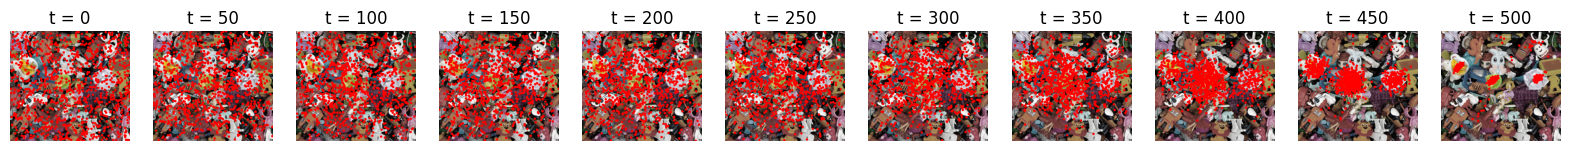

In [12]:
c = 10
fig,axs = plt.subplots(1, c + 1, figsize=(20,20))
axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 2

goals = gen_goals(goal_bounds, goal_num, dist=0.5)

objs = wastes.copy()
gs = goals.clone()

obs_T = overlay_images(bg, img_size, objs, gs)

imgs = []

model.eval()
with torch.no_grad():
    # x_T = torch.tensor([[0.5, 0.5]], device=device, dtype=torch.float32)
    x_T = gen_goals(agent_bounds, n=(1, eval_samples)).unsqueeze(0)
    x = x_T
    
    imgs=[]
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            img_sample = overlay_goals_agent(bg, objs, gs.cpu(), x.cpu(), dot_size)
            axs[k].imshow(img_sample)
            axs[k].set_title(f't = {T-1-i}')
            axs[k].axis('off')
        im = overlay_goals_agent(bg.copy(), objs, gs.cpu(), x.cpu(), dot_size)
        imgs.append(im)

        t = (torch.ones(1) * i).long().to(device)
        while True:
            predicted_noise = model(obs_T, x, t)
            alpha = diffusion.alpha[t]
            alpha_hat = diffusion.alpha_hat[t]
            beta = diffusion.beta[t]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                        * predicted_noise) + torch.sqrt(beta) * noise
            # if (abs(x[0][0]) <= 1.) & (abs(x[0][1]) <= 1.):
            #     break
            mask = (x.abs() > 1)
            x[mask] = torch.clamp(x[mask], min=-.9, max=.9)
            if (x.abs() <=1).all():
                break

#         exclude_idx = -1
#         for i in range(len(gs)):
#             if get_distance(x[0], gs[i]) < 0.1 and len(gs) > 1:
#                 exclude_idx = i
#                 break
#         if exclude_idx > -1:
#             objs = objs[:i] + objs[i+1:]
#             gs = torch.cat([gs[:i], gs[i+1:]], dim=0)
#             obs_T = overlay_images(bg, img_size, objs, gs)

    img_sample = overlay_goals_agent(bg, objs, gs.cpu(),x.cpu(), dot_size)
    axs[-1].imshow(img_sample)
    axs[-1].set_title(f't = {T}')
    axs[-1].axis('off')
    im = overlay_goals_agent(bg.copy(), objs, gs.cpu(), x.cpu(), dot_size)
    imgs.append(im)

In [13]:
np.save('./results/new_goals_video/img_list.npy', imgs)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [38]:
import numpy as np
import cv2
import glob
import torch
import matplotlib.pyplot as plt

imgss = np.load('./results/new_goals_video/img_list.npy', allow_pickle=True)
sample_img = np.array(imgss[0])
height, width, layers = sample_img.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('./video.mp4', fourcc, 50, (width, height))

for i, pil_img in enumerate(imgss):
    img_array = np.array(pil_img)
    out.write(img_array)
out.release()
cv2.destroyAllWindows()


error: OpenCV(4.6.0) /opencv-4.6.0/modules/highgui/src/window.cpp:1261: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [36]:
out

< cv2.VideoWriter 0x7f6a3c12d550>